# Installing dependencies

In [1]:
! pip install livelossplot

In [2]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Code to keep colab running
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, top_percent, size):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

def random_ratio_resize(img, prob=0.3, delta=0.1):
    if np.random.rand() >= prob:
        return img
    ratio = img.shape[0] / img.shape[1]
    ratio = np.random.uniform(max(ratio - delta, 0.01), ratio + delta)

    if ratio * img.shape[1] <= img.shape[1]:
        size = (int(img.shape[1] * ratio), img.shape[1])
    else:
        size = (img.shape[0], int(img.shape[0] / ratio))

    dh = img.shape[0] - size[1]
    top, bot = dh // 2, dh - dh // 2
    dw = img.shape[1] - size[0]
    left, right = dw // 2, dw - dw // 2

    if size[0] > 480 or size[1] > 480:
        print(img.shape, size, ratio)

    img = cv2.resize(img, size)
    img = cv2.copyMakeBorder(img, top, bot, left, right, cv2.BORDER_CONSTANT,
                             (0, 0, 0))

    if img.shape[0] != 224 or img.shape[1] != 224:
        raise ValueError(img.shape, size)
    return img

_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = random_ratio_resize(img)
    img = _augmentation_transform.random_transform(img)
    return img

def _process_csv_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files


class BalanceCovidDataset(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(
            self,
            data_dir,
            csv_file,
            is_training=True,
            batch_size=8,
            input_shape=(224, 224),
            n_classes=3,
            num_channels=3,
            mapping={
                'normal': 0,
                'pneumonia': 1,
                'COVID-19': 2
            },
            shuffle=True,
            augmentation=apply_augmentation,
            covid_percent=0.3,
            class_weights=[1., 1., 6.],
            top_percent=0.08
    ):
        'Initialization'
        self.datadir = data_dir
        self.dataset = _process_csv_file(csv_file)
        self.is_training = is_training
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.mapping = mapping
        self.shuffle = True
        self.covid_percent = covid_percent
        self.class_weights = class_weights
        self.n = 0
        self.augmentation = augmentation
        self.top_percent = top_percent

        datasets = {'normal': [], 'pneumonia': [], 'COVID-19': []}
        for l in self.dataset:
            datasets[l.split()[2]].append(l)
        self.datasets = [
            datasets['normal'] + datasets['pneumonia'],
            datasets['COVID-19'],
        ]
        print(len(self.datasets[0]), len(self.datasets[1]))

        self.on_epoch_end()

    def __next__(self):
        # Get one batch of data
        batch_x, batch_y, weights = self.__getitem__(self.n)
        # Batch index
        self.n += 1

        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0

        return batch_x, batch_y, weights

    def __len__(self):
        return int(np.ceil(len(self.datasets[0]) / float(self.batch_size)))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            for v in self.datasets:
                np.random.shuffle(v)

    def __getitem__(self, idx):
        batch_x, batch_y = np.zeros(
            (self.batch_size, *self.input_shape,
             self.num_channels)), np.zeros(self.batch_size)

        batch_files = self.datasets[0][idx * self.batch_size:(idx + 1) *
                                       self.batch_size]

        # upsample covid cases
        covid_size = max(int(len(batch_files) * self.covid_percent), 1)
        covid_inds = np.random.choice(np.arange(len(batch_files)),
                                      size=covid_size,
                                      replace=False)
        covid_files = np.random.choice(self.datasets[1],
                                       size=covid_size,
                                       replace=False)
        for i in range(covid_size):
            batch_files[covid_inds[i]] = covid_files[i]

        for i in range(len(batch_files)):
            sample = batch_files[i].split()

            if self.is_training:
                folder = 'train'
            else:
                folder = 'test'

            x = process_image_file(os.path.join(self.datadir, folder, sample[1]),
                                   self.top_percent,
                                   self.input_shape[0])

            if self.is_training and hasattr(self, 'augmentation'):
                x = self.augmentation(x)

            x = x.astype('float32') / 255.0
            y = self.mapping[sample[2]]

            batch_x[i] = x
            batch_y[i] = y

        class_weights = self.class_weights
        weights = np.take(class_weights, batch_y.astype('int64'))

        return batch_x, keras.utils.to_categorical(batch_y, num_classes=self.n_classes), weights

# Preparation

## Prepare Covid-Net dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -qq drive/My\ Drive/AAII.zip

# Importing data

In [5]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np

np.random.seed(7)

train_data = pd.read_csv('drive/My Drive/train_split_v3.txt', header=None, sep=' ', names=['id','image', 'result', 'type1', 'type2'])
print(train_data.head())


test_data = pd.read_csv('drive/My Drive/test_split_v3.txt', header=None, sep=' ', names=['id','image', 'result', 'type1', 'type2'])
test_data.head(1)

image_height = 224
image_width = 224

  id                                              image     result type1 type2
0  3  SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....  pneumonia    PA   NaN
1  3  SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....  pneumonia    PA   NaN
2  3  SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...  pneumonia    PA   NaN
3  7  SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...  pneumonia    PA   NaN
4  7  SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...  pneumonia    PA   NaN


In [6]:
print(train_data['result'].unique())
train_data[train_data['result'] == 'COVID-19'].count()

['pneumonia' 'COVID-19' 'normal']


id        223
image     223
result    223
type1     196
type2      27
dtype: int64

In [7]:
print(test_data['result'].unique())
test_data[test_data['result'] == 'COVID-19'].count()

['pneumonia' 'COVID-19' 'normal']


id        31
image     31
result    31
type1     31
type2      8
dtype: int64

In [14]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32 #10

train_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2
)

test_generator = ImageDataGenerator(
    rescale=1/255
)

train_set = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='image',
    directory="data/train/",
    y_col='result',
    shuffle=True,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="data/test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)


covid_balancer_generator = BalanceCovidDataset(
        data_dir="data",
        csv_file="drive/My Drive/train_split_v3.txt",
        batch_size=32,
        input_shape=(224, 224),
        covid_percent=0.3,
        class_weights=[1., 1., 6],
        top_percent=0.08
)

test_set_balancer = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="data/test/",
    y_col='result',
    shuffle=False,
    target_size=(224, 224),
    batch_size = 32,
    class_mode='categorical'
)

Found 13640 validated image filenames belonging to 3 classes.
Found 1510 validated image filenames belonging to 3 classes.
13417 223
Found 1510 validated image filenames belonging to 3 classes.


## Analysing Data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


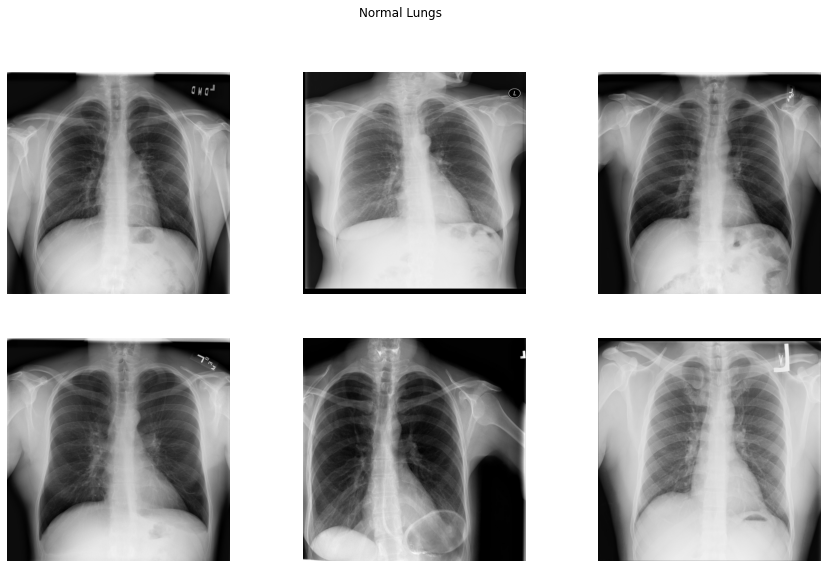

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'normal']['image']

for i in range(0,6):
  im = cv2.imread('data/train/' + samples_normal.iloc[i])
  print(im.shape)
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

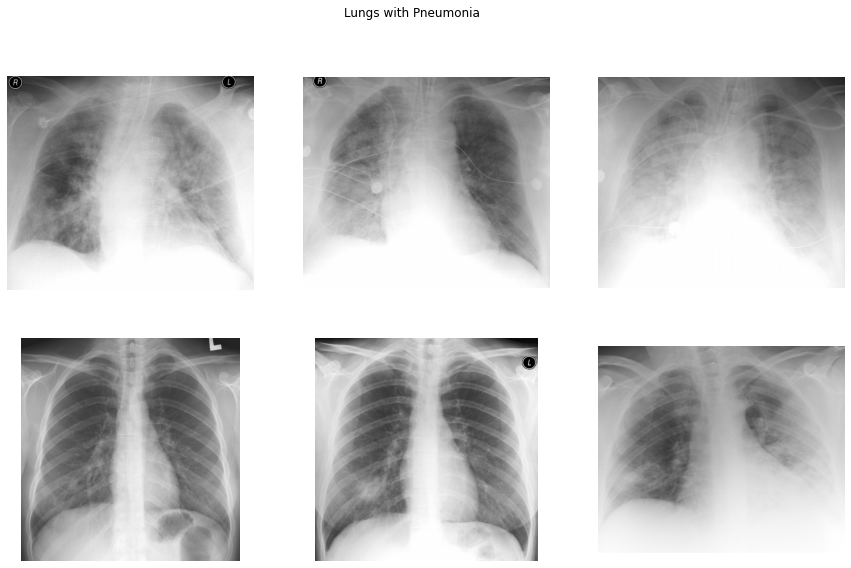

In [16]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'pneumonia']['image']

for i in range(0,6):
  im = cv2.imread('data/train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Lungs with Pneumonia')
plt.show()

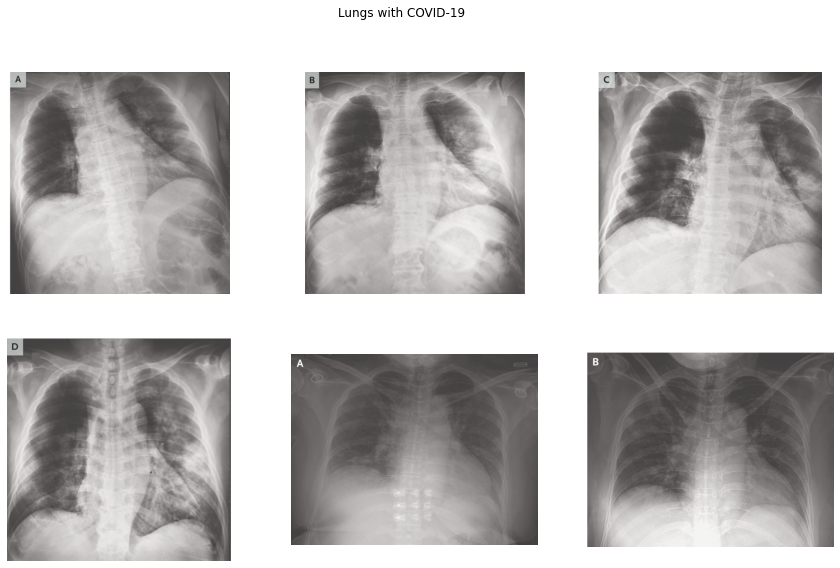

In [17]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'COVID-19']['image']

for i in range(0,6):
  im = cv2.imread('data/train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Lungs with COVID-19')
plt.show()

<Figure size 432x288 with 0 Axes>

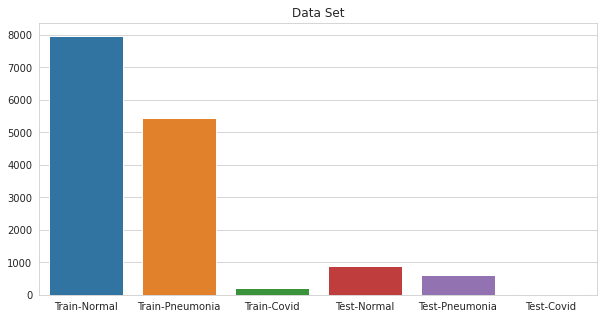

In [18]:
sns.set_style('whitegrid')
plt.figure()
plt.subplots(figsize=(10,5))
grafico=sns.barplot(x=['Train-Normal','Train-Pneumonia','Train-Covid','Test-Normal','Test-Pneumonia','Test-Covid'],
                    y=[train_data[train_data['result'] == 'normal'].shape[0],
                       train_data[train_data['result'] == 'pneumonia'].shape[0],
                       train_data[train_data['result'] == 'COVID-19'].shape[0],
                       test_data[test_data['result'] == 'normal'].shape[0],
                       test_data[test_data['result'] == 'pneumonia'].shape[0],
                       test_data[test_data['result'] == 'COVID-19'].shape[0]
                    ]) 
grafico.set_title('Data Set')
plt.show()

# Developing model

## Auxiliary Functions

In [0]:
import os

def save_model_on_cloud(model,name,ind):
  path="/content/drive/My Drive/covid_runs/run"+ind
  os.makedirs(path)
  model.save_weights(path + "/last_run" + name + ".hdf5")
  json_model = model.to_json()
  with open(path + "/" + name + ".json", "w") as json_file:
    json_file.write(model_json)
  os.rename("best_weights_" + name + ".hdf5", path + "/best_weights_" + name + ".hdf5")

In [0]:
from keras.models import model_from_json
import json

def load_model_from_cloud(model_path, weights_path):
  with open(model_path, 'r') as json_file:
    architecture  = json.load(json_file)
    model = model_from_json(json.dumps(architecture))
  model.load_weights(weights_path)
  return model

In [0]:
import cv2
def query_model(model, img):
  tmp_image = cv2.imread(img)
  tmp_image = np.array(tmp_image)
  tmp_image = cv2.resize(tmp_image, (image_width, image_height))
  tmp_image = tmp_image / 255
  res = model.predict(np.expand_dims(tmp_image, axis=0))
  print(test_set.class_indices)
  ind = np.argmax(res)
  print(ind)
  print([t * 100 for t in res])

## Importing pre-trained model -> ResNet50

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
import keras
from keras.models import Model
from keras.optimizers import Adam



image_height = 224
image_width = 224

resnet = keras.applications.ResNet50(weights='imagenet',include_top=False, input_shape = (image_width, image_height, 3))


new_model = resnet.output
new_model = GlobalAveragePooling2D()(new_model)
new_model = Dense(512, activation="relu")(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(128, activation="relu")(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(3, activation="softmax")(new_model)

final_Model = Model(inputs=resnet.input, outputs=new_model)

for layer in final_Model.layers[:174]:
    layer.trainable = False



opt = Adam(0.0001)
final_Model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


final_Model.summary()

In [11]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 20 #10
path="/content/drive/My Drive/covid_runs/resnet50/"

os.makedirs(path)
json_model = final_Model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_resnet50.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = final_Model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

final_Model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

FileExistsError: ignored

In [0]:
## Testing the Model

In [0]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/resnet50/model.json", "/content/drive/My Drive/covid_runs/resnet50/best_weights_resnet50.hdf5")
model_cloud.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="data/test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

TypeError: ignored

In [0]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [0]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res)
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

In [0]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')